# Three-particle potentials

In this notebook we'll explore the Stillinger-Weber three-particle potential applied to a system of silicon (Si) atoms.
The Stillinger-Weber potential is given by a two-particle potential similar to Lennard-Jones and a three-particle potential.
\begin{align}
    U(r)
    = \sum_{ij} U(r_{ij})
    + \sum_{ijk} U(r_{ij}, r_{ik}, \theta_{ijk}).
\end{align}
The two-particle potential is given by
\begin{align}
    U(r_{ij})
    = A \epsilon\left[
        B \left(
            \frac{\sigma}{r_{ij}}
        \right)^{p}
        - \left(
            \frac{\sigma}{r_{ij}}
        \right)^{q}
    \right]
    \exp\left(
        \frac{\sigma}{r_{ij} - a\sigma}
    \right),
\end{align}
where $A$, $B$, $\epsilon$, $\sigma$, $p$, $q$ and $a$ are coefficients that can be adjusted depending on the system we are perusing.
The three-particle potential has the form
\begin{align}
    U(r_{ij}, r_{ik}, \theta_{ijk})
    = \lambda \epsilon \left[
        \cos(\theta_{ijk})
        - \cos(\theta_{0})
    \right]^2
    \exp\left(
        \frac{\gamma\sigma}{r_{ij} - a\sigma}
    \right)
    \exp\left(
        \frac{\gamma\sigma}{r_{ik} - a\sigma}
    \right),
\end{align}
where we've introduced the new parameters $\lambda$ and $\gamma$.
Note that we've simplified the potentials as we've removed the indices that can be associated with every coefficient to specify different types of interactions between atoms.
Below we use the given parameter file.

In [17]:
import os
import re
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model

from read_lammps_log import read_log, get_temp_lognames, read_rdf_log
from diffusion import get_diffusion_constant

sns.set(color_codes=True)

In [4]:
%%writefile scripts/Si.sw
# DATE: 2007-06-11 CONTRIBUTOR: Aidan Thompson, athomps@sandia.gov
# CITATION: Stillinger and Weber,  Phys Rev B, 31, 5262, (1985)
# Stillinger-Weber parameters for various elements and mixtures
# multiple entries can be added to this file,
# LAMMPS reads the ones it needs
# these entries are in LAMMPS "metal" units:
#   epsilon = eV; sigma = Angstroms
#   other quantities are unitless
# format of a single entry (one or more lines):
#   element 1, element 2, element 3,
#   epsilon, sigma, a, lambda, gamma, costheta0, A, B, p, q, tol
# Here are the original parameters in metal units, for Silicon from:
#
# Stillinger and Weber,  Phys. Rev. B, v. 31, p. 5262, (1985)
#

Si # element 1
Si # element 2
Si # element 3
2.1683 # epsilon
2.0951 # sigma
1.80 # a
21.0 # lambda
1.20 # gamma
-0.333333333333 # cos(theta_0)
7.049556277 # A
0.6022245584 # B
4.0 # p
0.0 # q
0.0 # tol

Overwriting scripts/Si.sw


In the Lennard-Jones-scripts we only specify $\epsilon$, $\sigma$ and $r_c$ (cut-off).
Furthermore, we see that for $A = 4$, $B = 1$, $p = 12$, and $q = 6$ we almost recover the Lennard-Jones potential in the two-particle potential if we remove the exponential cut-off function.
With $p = 4$ we lower the repulsive effect of the two-particle potential and by setting $q = 0$ we use a fixed attractive force between the particles.

In [10]:
%%writefile scripts/si.in

units           metal
atom_style      atomic
atom_modify     map array
boundary        p p p
atom_modify     sort 0 0.0

# temperature
#variable T equal 1200.0

# diamond unit cell
variable myL equal 10
variable myscale equal 1.3
variable bins equal 200

variable a equal 5.431*${myscale}
lattice         custom $a               &
                a1 1.0 0.0 0.0          &
                a2 0.0 1.0 0.0          &
                a3 0.0 0.0 1.0          &
                basis 0.0 0.0 0.0       &
                basis 0.0 0.5 0.5       &
                basis 0.5 0.0 0.5       &
                basis 0.5 0.5 0.0       &
                basis 0.25 0.25 0.25    &
                basis 0.25 0.75 0.75    &
                basis 0.75 0.25 0.75    &
                basis 0.75 0.75 0.25

region          myreg block     0 ${myL} &
                                0 ${myL} &
                                0 ${myL}

create_box      1 myreg
create_atoms    1 region myreg

mass            1       28.06

group Si type 1

velocity all create ${T} 5287286 mom yes rot yes dist gaussian

pair_style      sw
pair_coeff * * scripts/Si.sw Si

neighbor        1.0 bin
neigh_modify    every 1 delay 10 check yes

timestep        1.0e-3
#fix             1 all nve
# Try using fix npt
fix             1 all nvt temp ${T} ${T} 0.05

# Run simulation
thermo          10
#dump 1 all custom 10 dat/si.lammpstrj id type x y z vx vy vz
run             1000


reset_timestep 0
variable time equal dt*step
compute msd all msd
compute myrdf all rdf ${bins}

fix 2 all ave/time 100 1 100 c_myrdf[*] file dat/si_rdf_${T}.log mode vector

thermo_style custom step v_time temp ke pe etotal press c_msd[4]

log dat/si_g_${T}.log

run 5000

Overwriting scripts/si.in


In [32]:
%%writefile scripts/run_si.in

export OMP_NUM_THREADS=4

for T in $(seq 1 200 6001); do
    mpirun -np 4 lmp -var T $T -in scripts/si.in
done

Overwriting scripts/run_si.in


In [40]:
temperature_list, file_list = get_temp_lognames("si_g")

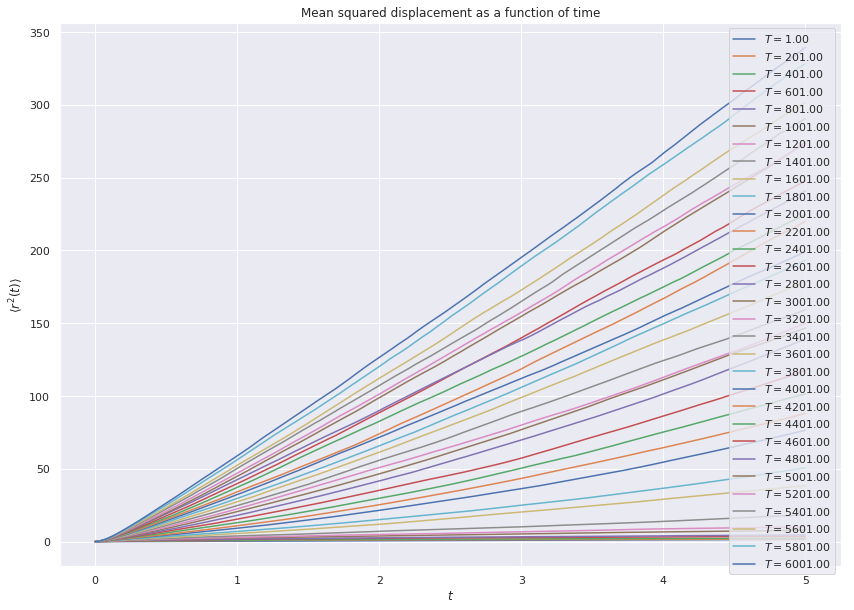

In [41]:
fig = plt.figure(figsize=(14, 10))

log_df_list = []

for T, filename in zip(temperature_list, file_list):
    log_df = read_log(filename)
    log_df_list.append(log_df)
    plt.plot(
        log_df["v_time"],
        log_df["c_msd[4]"],
        label=fr"$T = {T:.2f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t)\rangle$")
plt.legend(loc="best")
plt.title(r"Mean squared displacement as a function of time")
plt.show()

In [42]:
D_list = []
alpha_list = []

for T, log_df in zip(temperature_list, log_df_list):
    D, D_int, alpha, alpha_int = get_diffusion_constant(log_df)

    D_list.append(D)
    alpha_list.append(alpha)

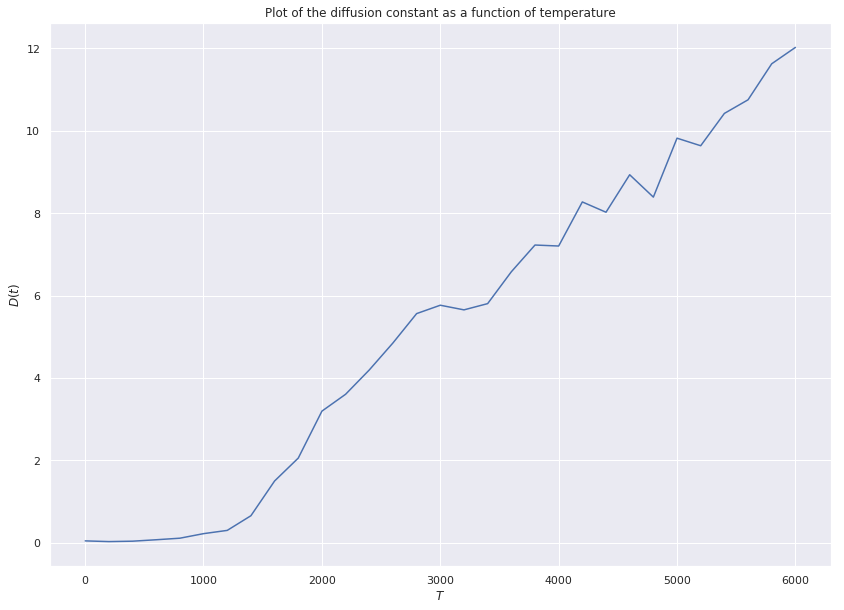

In [43]:
fig = plt.figure(figsize=(14, 10))

plt.plot(temperature_list, D_list)
plt.title(r"Plot of the diffusion constant as a function of temperature")
plt.xlabel(r"$T$")
plt.ylabel(r"$D(t)$")
plt.show()

In [44]:
temperature_list, rdf_list = get_temp_lognames("si_rdf")

In [45]:
g_r_dict = {}
bin_centers_dict = {}

for temp, filename in zip(temperature_list, rdf_list):
    bin_centers, g_r = read_rdf_log(filename)

    g_r_dict[temp] = g_r
    bin_centers_dict[temp] = bin_centers

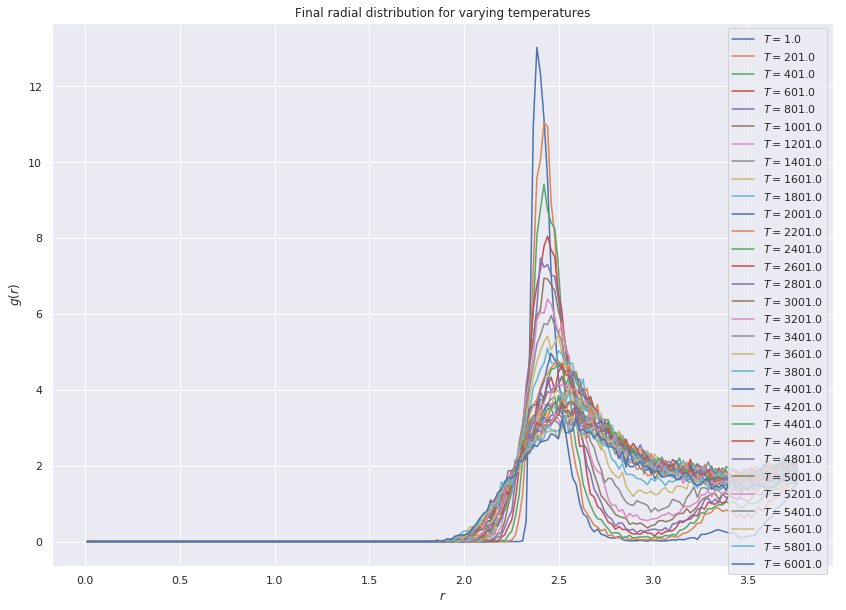

In [57]:
fig = plt.figure(figsize=(14, 10))

for i, temp in enumerate(temperature_list):
    key = max(g_r_dict[temp])

    plt.plot(
        bin_centers_dict[temp][key],
        g_r_dict[temp][key],
        label=fr"$T = {temp}$",
    )

plt.xlabel(r"$r$")
plt.ylabel(r"$g(r)$")
plt.legend(loc="best")
plt.title(r"Final radial distribution for varying temperatures")
plt.show()